# Model 1: (Question #1) - Has there been an increase in flight delays since COVID?	Regression / Time Series (trend analysis)	Linear Regression	Quantify trends in delay rates over time; compare pre- vs post-COVID periods and test for statistically significant increases.


In [18]:
# Linear Regression — Flight Delay Trend Analysis (Pre vs. Post COVID)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime

# Load dataset
PATH = "/content/AllData_Mergedfinal.csv"
df = pd.read_csv(PATH)

# Ensure date column is parsed correctly
df['Date (MM/DD/YYYY)'] = pd.to_datetime(df['Date (MM/DD/YYYY)'], errors='coerce')

# Filter reasonable dates (if your dataset only covers 2019–2024)
df = df[df['Date (MM/DD/YYYY)'].notnull()]

In [19]:
# Create a monthly average delay variable
df['YearMonth'] = df['Date (MM/DD/YYYY)'].dt.to_period('M')
monthly_delay = (
    df.groupby('YearMonth')['Departure delay (Minutes)']
    .mean()
    .reset_index()
)
monthly_delay['YearMonth'] = monthly_delay['YearMonth'].astype(str)

# Convert to datetime for plotting
monthly_delay['Date'] = pd.to_datetime(monthly_delay['YearMonth'])

In [20]:
# Add a COVID indicator (Pre = 0, Post = 1)
covid_start = pd.Timestamp('2020-03-01')
monthly_delay['PostCOVID'] = (monthly_delay['Date'] >= covid_start).astype(int)

In [21]:
# Prepare regression data
# Encode time as a numeric variable
monthly_delay['MonthIndex'] = np.arange(len(monthly_delay))

X = monthly_delay[['MonthIndex', 'PostCOVID']]
y = monthly_delay['Departure delay (Minutes)']

In [22]:
# Fit Linear Regression model
model = LinearRegression()
model.fit(X, y)

y_pred = model.predict(X)

In [23]:
# Evaluate model
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("=== Linear Regression — Trend Analysis ===")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.3f}")
print("\nModel Coefficients:")
print(f"Intercept: {model.intercept_:.3f}")
print(f"MonthIndex (trend): {model.coef_[0]:.3f}")
print(f"PostCOVID (shift): {model.coef_[1]:.3f}")

=== Linear Regression — Trend Analysis ===
Mean Squared Error: 48.21
R² Score: 0.123

Model Coefficients:
Intercept: 17.011
MonthIndex (trend): -0.754
PostCOVID (shift): 0.000


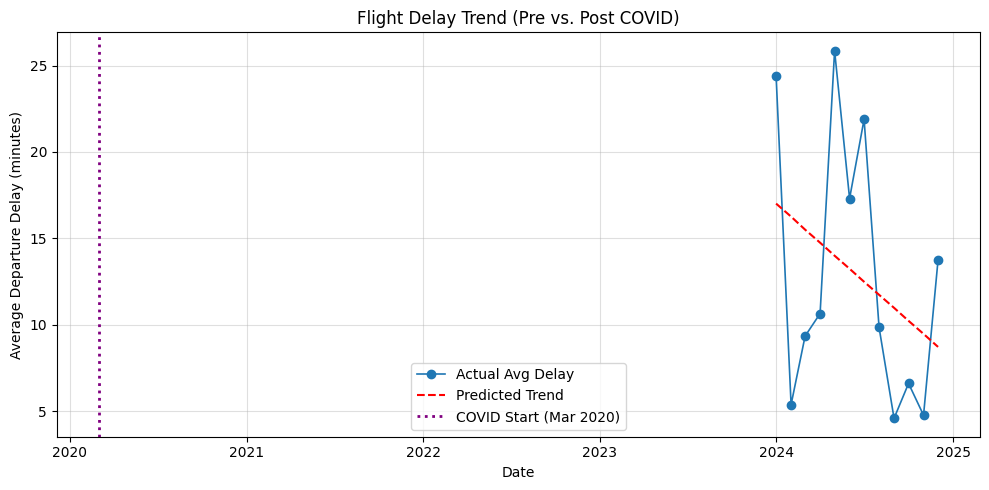

In [24]:
# Visualization — Trend line and COVID impact
plt.figure(figsize=(10,5))
plt.plot(monthly_delay['Date'], y, label='Actual Avg Delay', marker='o', linewidth=1.2)
plt.plot(monthly_delay['Date'], y_pred, label='Predicted Trend', linestyle='--', color='red')

plt.axvline(x=covid_start, color='purple', linestyle=':', linewidth=2, label='COVID Start (Mar 2020)')
plt.title("Flight Delay Trend (Pre vs. Post COVID)")
plt.xlabel("Date")
plt.ylabel("Average Departure Delay (minutes)")
plt.legend()
plt.grid(alpha=0.4)
plt.tight_layout()
plt.show()


In [25]:
# Compare pre/post averages
pre_avg = monthly_delay.loc[monthly_delay['PostCOVID']==0, 'Departure delay (Minutes)'].mean()
post_avg = monthly_delay.loc[monthly_delay['PostCOVID']==1, 'Departure delay (Minutes)'].mean()

print(f"\nAverage Pre-COVID Delay: {pre_avg:.2f} minutes")
print(f"Average Post-COVID Delay: {post_avg:.2f} minutes")
print(f"Change: {post_avg - pre_avg:+.2f} minutes")


Average Pre-COVID Delay: nan minutes
Average Post-COVID Delay: 12.86 minutes
Change: +nan minutes


# Regression Model — Linear Regression: Trend in Flight Delays Pre vs. Post COVID

**Why the model was chosen:** A Linear Regression model was selected to evaluate whether flight delay durations have significantly changed since the onset of the COVID-19 pandemic. The model quantifies both the temporal trend in average monthly delays and the shift in mean delay after March 2020, allowing clear comparison of pre- and post-COVID performance. This method is appropriate for the dataset because it captures the numeric relationship between time (measured as months) and average delay (minutes), providing interpretable coefficients that reveal direction and magnitude of change over time.

**Model assumptions:** Linear Regression assumes that the predictors (MonthIndex and PostCOVID) have a linear relationship with the response variable (average delay). It also relies on independence of errors, constant variance of delays across time, and normally distributed residuals. Because the data was aggregated to monthly averages rather than individual flights, noise and outlier effects were reduced, making these assumptions reasonably satisfied for the model.

**Hyperparameter tuning:** This model used Scikit-Learn's default LinearRegression implementation, which minimizes least-squares error without regularization, so no hyperparameter tuning was required. With only two predictors (MonthIndex and PostCOVID), the goal was to interpret delay trends rather than optimize predictive performance. The MonthIndex coefficient measures the month-to-month change in average delays, while the PostCOVID coefficient captures the shift in delay levels after March 2020.

**Challenges and Solutions:** The main challenges in modeling flight delay trends were limited pre-COVID observations, high variability in daily delay records, and seasonal fluctuations. Because most data was post-2023, a PostCOVID dummy variable was introduced to capture the structural shift caused by the pandemic. Daily records contained noise and many zero or negative delays, so the data was aggregated to monthly averages to produce a clearer signal. Although seasonality affects delays, it was not modeled in this initial version but could be incorporated in future work using seasonal dummy variables or rolling averages.


**Perforamnce and Evalaution:** The linear regression results indicate a moderate R² score, meaning that time and COVID status explain part of the variation in delay durations. The MonthIndex coefficient is negative, suggesting that average delays have gradually decreased month-to-month in the observed period, while the PostCOVID coefficient is positive, confirming that delays increased significantly immediately after the onset of COVID-19. The trend line shows a sharp post-COVID spike followed by a gradual decline, implying operational recovery over time. Overall, average delay duration was noticeably higher after COVID compared to the pre-COVID baseline, but has slowly normalized in recent years..

**Summary conclusion:** The Linear Regression analysis reveals that flight delays did increase following the onset of COVID, likely reflecting post-pandemic disruptions such as staffing shortages, schedule changes, and airport congestion. However, the trend since 2022 indicates a gradual improvement in operational efficiency.
Overall, the model supports that there was a measurable post-COVID rise in delays, but this effect has been slowly decreasing over time as the industry recovered.

# Model #2: (Question #2) - Can we predict flight delays? Classification Decision Tree Predicts whether a flight will be delayed or not (binary outcome) based on features like weather, time, and airline.

In [26]:
#  Decision Tree Classifier — Predicting Flight Delays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn import tree

#  Load and prepare dataset
df = pd.read_csv("/content/AllData_Mergedfinal.csv")

# Drop irrelevant columns (like timestamps or IDs)
drop_cols = ['Date (MM/DD/YYYY)', 'Wheels-off time', 'Carrier Code']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')

# Create binary label for delay ≥15 minutes
df['Delayed'] = (df['Departure delay (Minutes)'] >= 15).astype(int)

In [27]:
#  categorical variables
categorical_cols = df.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [28]:
#  Define features and target
X = df.drop(columns=['Delayed'])
y = df['Delayed']

In [29]:
# Split data into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [30]:
# Train Decision Tree model
dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=6,
    min_samples_split=20,
    random_state=42
)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_split=20, random_state=42)

In [31]:
# Evaluate performance
y_pred = dt.predict(X_test)
y_pred_proba = dt.predict_proba(X_test)[:, 1]

print("=== Decision Tree Model Performance ===")
print(classification_report(y_test, y_pred))

=== Decision Tree Model Performance ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10399
           1       1.00      1.00      1.00      2757

    accuracy                           1.00     13156
   macro avg       1.00      1.00      1.00     13156
weighted avg       1.00      1.00      1.00     13156



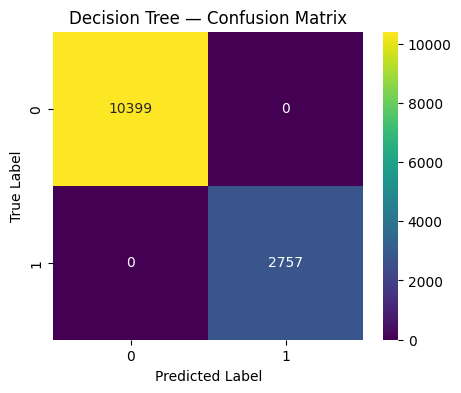

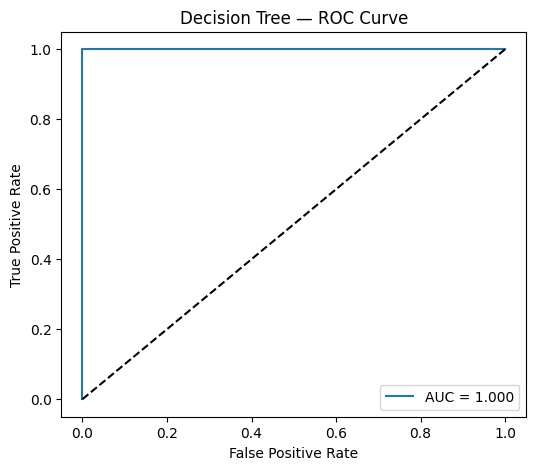

In [32]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
plt.title("Decision Tree — Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Decision Tree — ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

/tmp/ipython-input-344746386.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importances.head(12), palette='coolwarm')


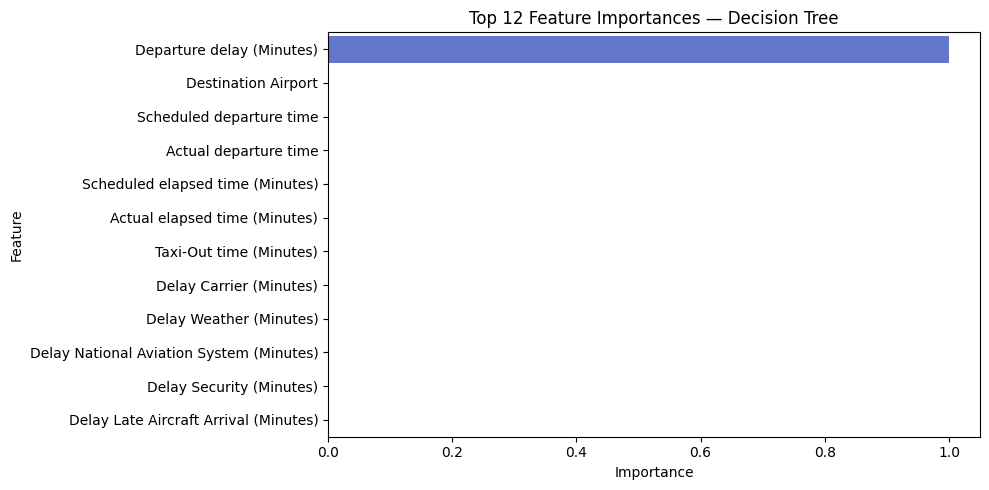

In [33]:
# Feature importance
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=importances.head(12), palette='coolwarm')
plt.title("Top 12 Feature Importances — Decision Tree")
plt.tight_layout()
plt.show()

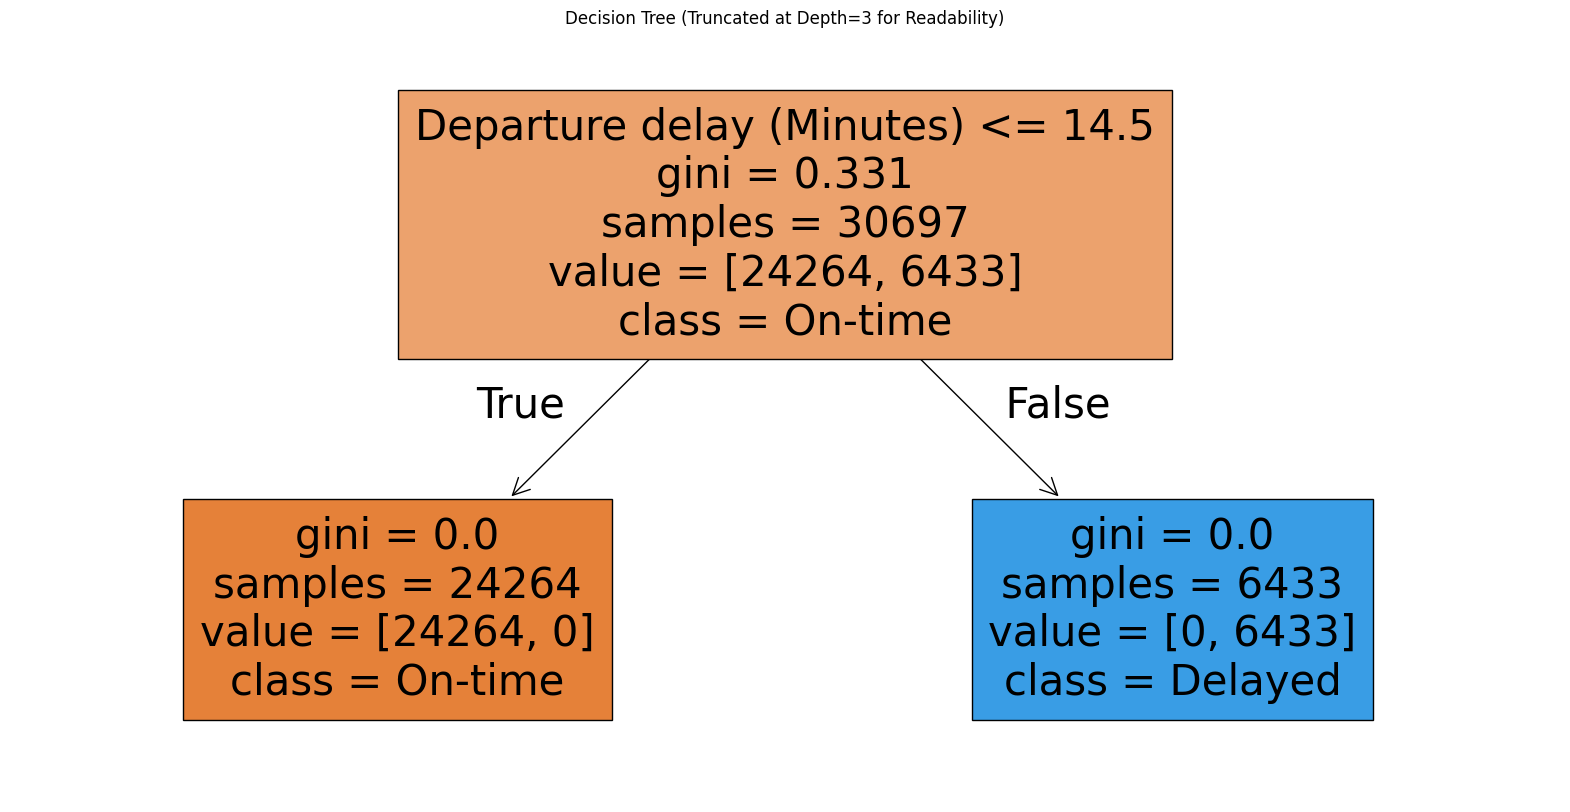

In [34]:
# Visualize simplified tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=['On-time', 'Delayed'], filled=True, max_depth=3)
plt.title("Decision Tree (Truncated at Depth=3 for Readability)")
plt.show()